## Image Captioning using LSTM
The dataset used is Flickr8k, which is a collection of 8,000 images, each accompanied by five human-generated captions, used for training and evaluating image captioning models.

In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical, plot_model

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('captions.txt')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


### Caption text preprocessing steps
 - Convert sentences into lowercase
 - Remove special characters and numbers
 - Remove extra spaces
 - Remove single characters
 - Add a starting and ending tag to indicate beginning and ending of a sentence

In [3]:
def preprocess(df):
    df['caption'] = df['caption'].apply(lambda x: x.lower())
    df['caption'] = df['caption'].apply(lambda x: re.sub("[^A-Za-z]", "", x))
    df['caption'] = df['caption'].apply(lambda x: re.sub("\s+", " ", x))
    df['caption'] = df['caption'].apply(lambda x: " ".join([w for w in x.split() if len(w) > 1]))
    df['caption'] = df['caption'].apply(lambda x: f"startseq {x.strip()} endseq")
    return df

In [4]:
df = preprocess(df)
captions = df['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

### Tokenization and Encoding

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8485

In [6]:
max_length = max(len(c.split()) for c in captions)
max_length

34

In [7]:
dfg = df.groupby('image')['caption'].apply(list).reset_index()
dfg.head()

,image,caption
0,1000268201_693b08cb0e.jpg,[startseq child in pink dress is climbing up s...
1,1001773457_577c3a7d70.jpg,[startseq black dog and spotted dog are fighti...
2,1002674143_1b742ab4b8.jpg,[startseq little girl covered in paint sits in...
3,1003163366_44323f5815.jpg,[startseq man lays on bench while his dog sits...
4,1007129816_e794419615.jpg,[startseq man in an orange hat starring at som...


### Train test split

In [8]:
nimg = len(dfg)

splt_indx = int(nimg*0.85)
train_df = dfg[:splt_indx]
test_df = dfg[splt_indx:]

train = dfg[dfg['image'].isin(train_df['image'])]
test = dfg[dfg['image'].isin(test_df['image'])]

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

### Feature Extraction with VGG16

In [9]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
features = {}

for img_name in tqdm(dfg['image']):
    img_path = os.path.join('Images', img_name)
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)
    
    feature = model.predict(img, verbose=0)
    img_id = img_name.split('.')[0]
    features[img_id] = feature

### Save features for future use
No need to re-run the model to extract features again.
Saves time

In [51]:
pickle.dump(features, open('features.pkl', 'wb'))

In [10]:
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

### Data Generation
Since model training is a very resource heavy process, we cannot load all the data into the main memory at once, so we need to generate the data in the required format, batch-wise.

The inputs will be the image embeddings (features) and their corresponding caption text embeddings (text encodings).

X1 is image features, X2 is in_seq, y is out_seq.

The out_seq is the most probable world after a series of in_seq words.

 - In: "The big brown fox", Out: "jumps"

 - In: "The big brown fox jumps", Out: "over"
 
and so on.

In [11]:
class DataGen(Sequence):
    def __init__(self, df, X_col, y_col, features, tokenizer, vocab_size, max_length, batch_size , shuffle=True):
        self.df = df
        self.X_col = X_col
        self.y_col = y_col
        self.features = features
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n = len(self.df)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self, idx):
        batch = self.df[idx*self.batch_size:(idx+1)*self.batch_size]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y
    
    def __get_data(self, batch):
        X1, X2, y = [], [], []
        images = batch[self.X_col].tolist()
        for image in images:
            feature = self.features[image.split('.')[0]][0]
            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()[0]
            for c in captions:
                seq = self.tokenizer.texts_to_sequences([c])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        return X1, X2, y

### Model Building

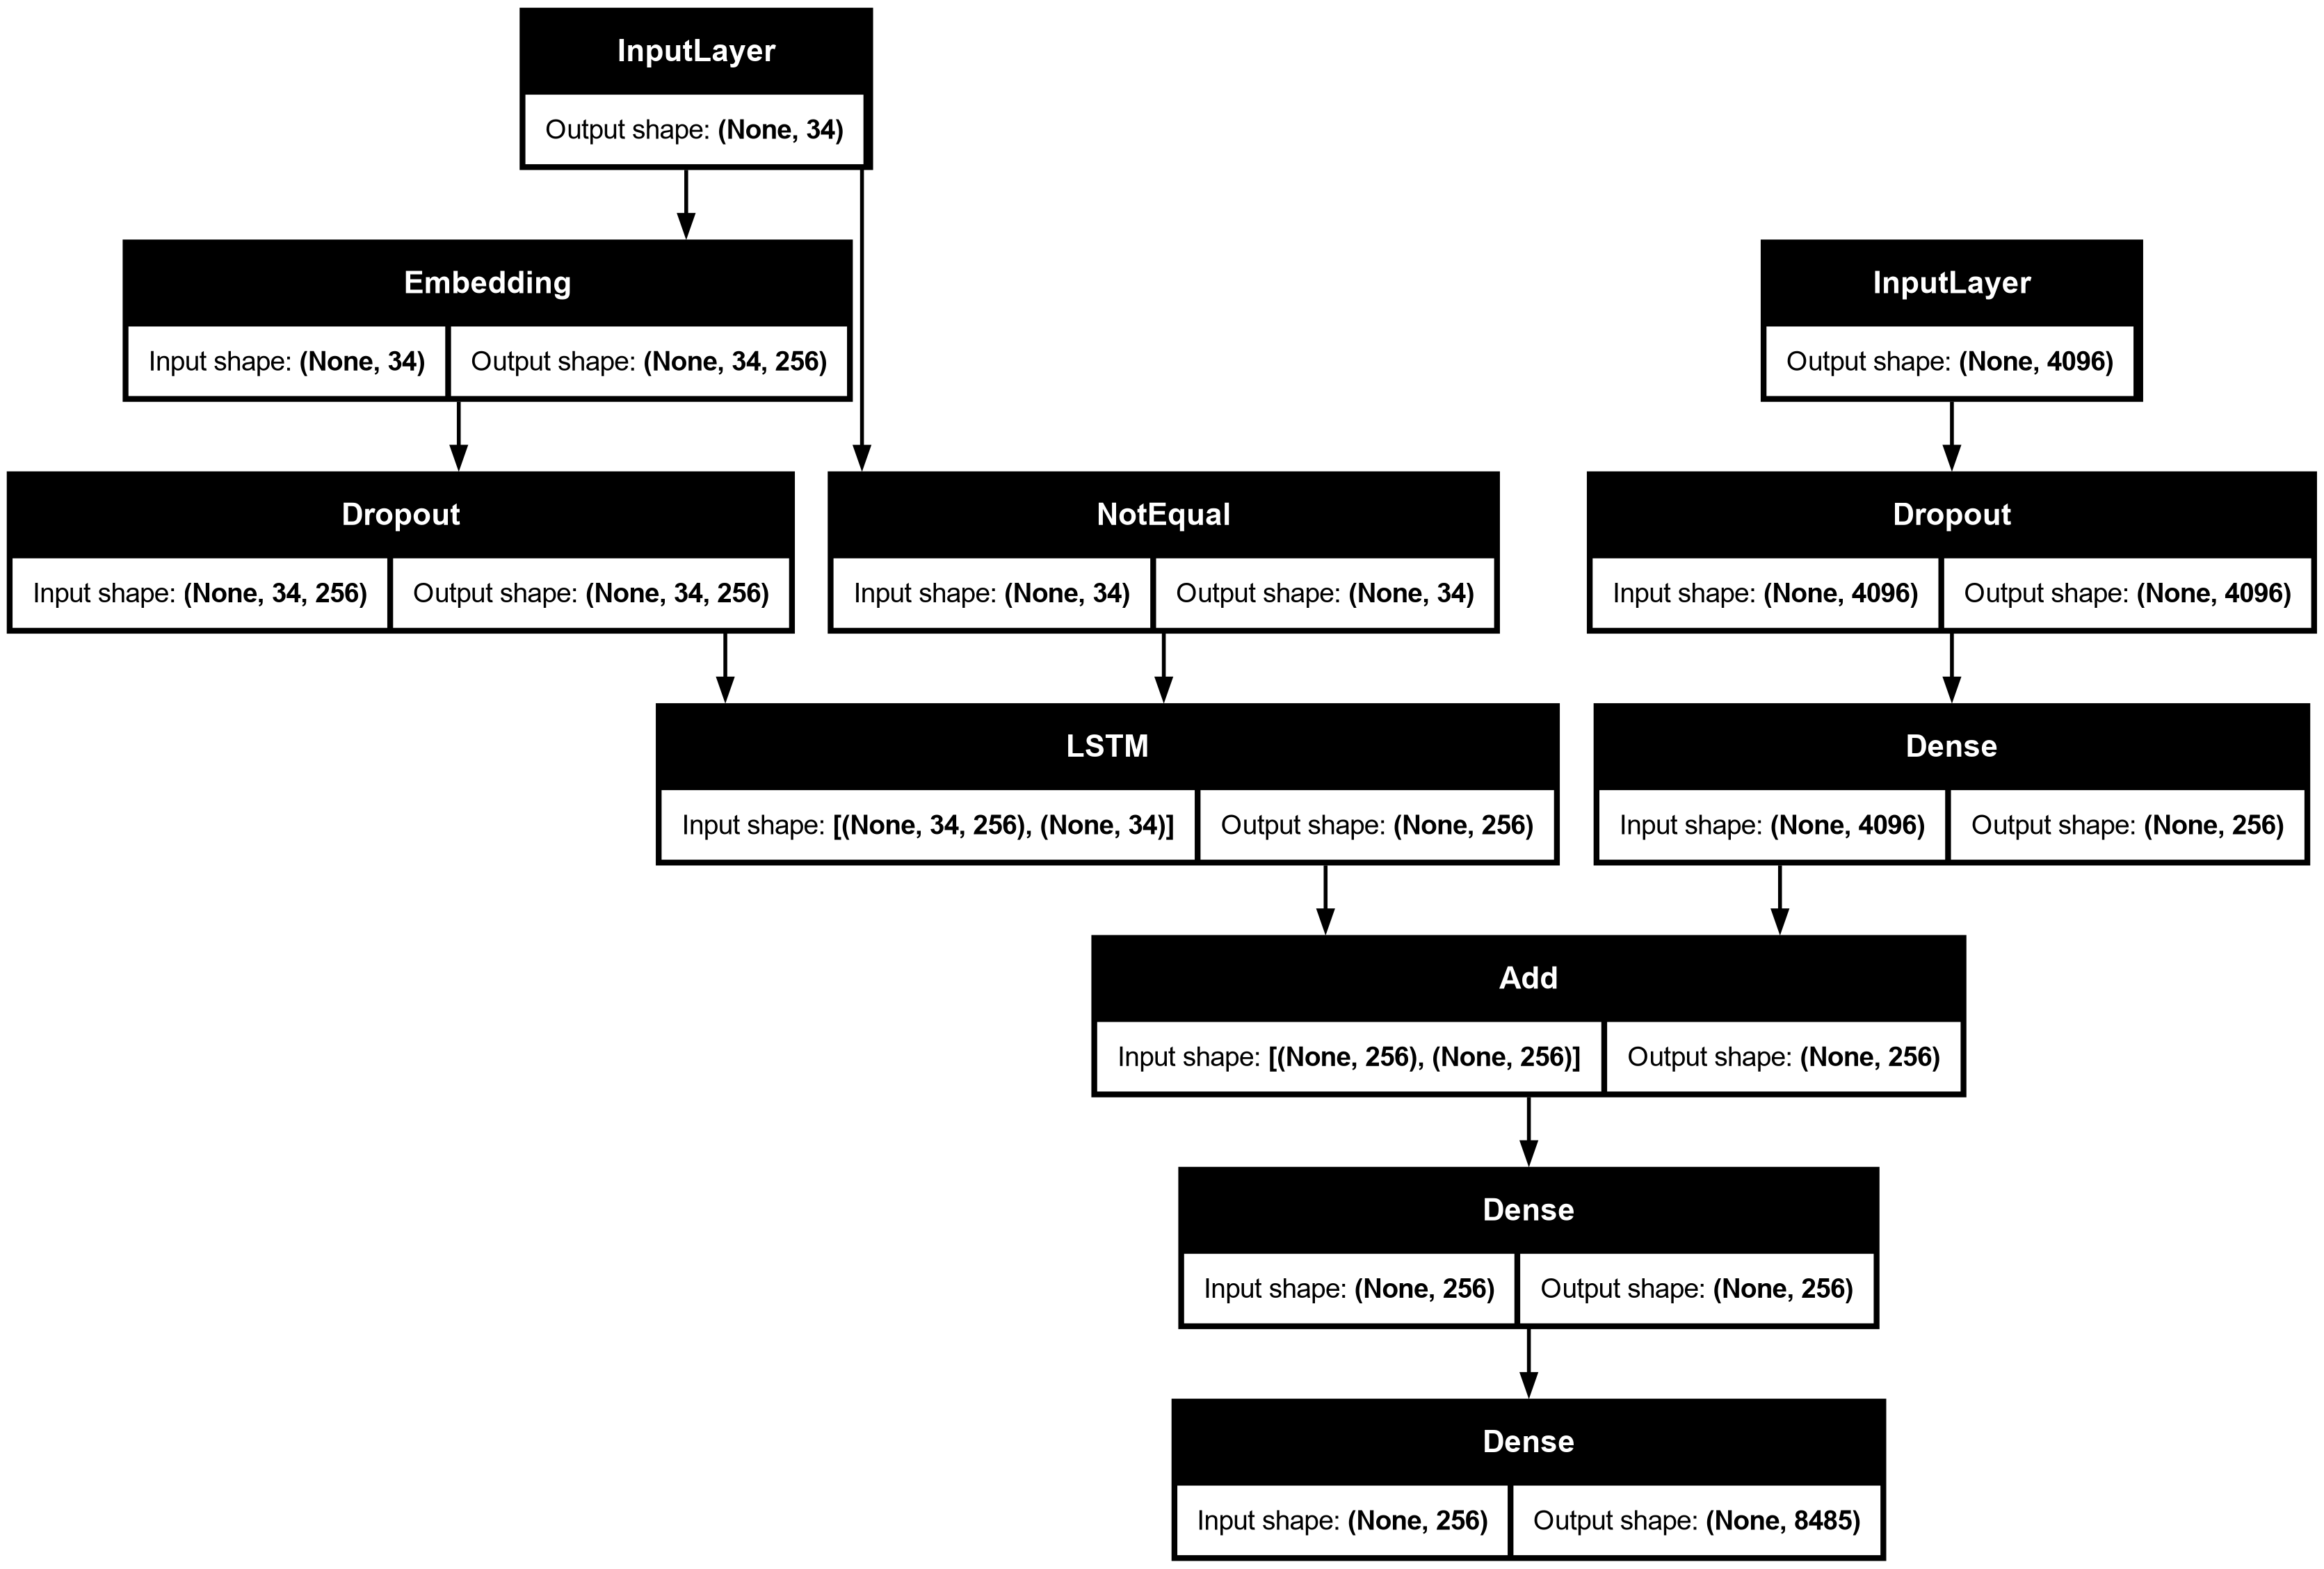

In [12]:
input1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(input1)
fe2 = Dense(256, activation='relu')(fe1)

input2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(input2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input1, input2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,172,160 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8485)      │  2,180,645 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,992,741 (22.86 MB)

 Trainable params: 5,992,741 (22.86 MB)

 Non-trainable params: 0 (0.00 B)

### Model training

In [118]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

train_gen = DataGen(
    df=train, 
    X_col='image', 
    y_col='caption', 
    features=features, 
    tokenizer=tokenizer, 
    vocab_size=vocab_size, 
    max_length=max_length, 
    batch_size=batch_size
)

model.fit(train_gen, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/20


2024-08-25 00:48:42.192603: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 108811640 exceeds 10% of free system memory.


214/214 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - loss: 5.8473
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - loss: 0.0000e+00
Epoch 3/20


2024-08-25 00:52:22.510477: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


214/214 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - loss: 4.1114
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 63us/step - loss: 0.0000e+00
Epoch 5/20


2024-08-25 00:56:00.962975: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


214/214 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - loss: 3.6014
Epoch 6/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - loss: 0.0000e+00
Epoch 7/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - loss: 3.2866
Epoch 8/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - loss: 0.0000e+00
Epoch 9/20


2024-08-25 01:04:02.983020: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


214/214 ━━━━━━━━━━━━━━━━━━━━ 211s 982ms/step - loss: 3.0567
Epoch 10/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 14us/step - loss: 0.0000e+00
Epoch 11/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 211s 980ms/step - loss: 2.8667
Epoch 12/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - loss: 0.0000e+00
Epoch 13/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - loss: 2.7152
Epoch 14/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 14us/step - loss: 0.0000e+00
Epoch 15/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 212s 986ms/step - loss: 2.6137
Epoch 16/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 12us/step - loss: 0.0000e+00
Epoch 17/20


2024-08-25 01:19:02.440368: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


214/214 ━━━━━━━━━━━━━━━━━━━━ 208s 967ms/step - loss: 2.5229
Epoch 18/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 12us/step - loss: 0.0000e+00
Epoch 19/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - loss: 2.4415
Epoch 20/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - loss: 0.0000e+00


### Save model for future use

In [119]:
model.save('lstm.keras')

In [14]:
model.load_weights('lstm.keras')

### Generate captions for the image

In [15]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [16]:
def predict_caption(model, features, tokenizer, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([features, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

### Model performance measure with bleu scores

In [17]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = [], []
for image in tqdm(test['image']):
    feature = features[image.split('.')[0]][0]
    feature = np.expand_dims(feature, axis=0)
    captions = test.loc[test['image'] == image, 'caption'].tolist()[0]
    act_caption = [c.split() for c in captions]

    y_pred = predict_caption(model, feature, tokenizer, max_length)
    y_pred = y_pred.split()

    actual.append(act_caption)
    predicted.append(y_pred)

print(f"BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}")
print(f"BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}")

100%|██████████| 1214/1214 [07:39<00:00,  2.64it/s]


BLEU-1: 0.5640414276134417
BLEU-2: 0.3429216641419326


### **Typical BLEU Score Ranges:**
- **BLEU Score > 30:**  
  This is generally considered **reasonable** and shows that the model is generating somewhat meaningful and relevant text.

- **BLEU Score > 50:**  
  Indicates **very good** performance, where generated text is highly similar to the reference text.

- **BLEU Score > 70:**  
  Rare and typically achieved in **restricted domains** (e.g., when there’s very little variation in language, such as technical instructions).

- **BLEU Score < 10:**  
  Implies that the generated output is **poorly aligned** with the reference. This could indicate a need for further tuning, better training data, or improvements to the model.

---

Since our model gets a BLEU-1 score of >50% for unigram, it has excellent keyword accuracy.

And with a BLEU-2 score of >30%, it has a good level of fluency, checking keyword pairs occur correctly.

### Visualize the Results

In [137]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join("Images", image_name)
    image = Image.open(img_path)
    captions = dfg.loc[dfg['image'] == image_name, 'caption'].tolist()[0]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
        
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq two people are skiing down snowy hill endseq


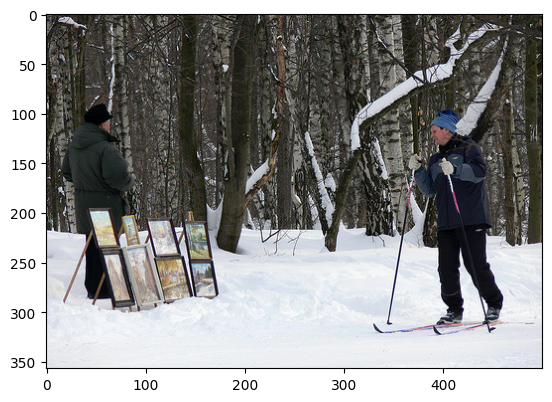

In [141]:
generate_caption("101669240_b2d3e7f17b.jpg")